<br />
## Going deep: Deep neural networks

So far, we've learned that if we want to classify more than two fruits, we'll need to go beyond using a single neuron and use *multiple* neurons to get multiple outputs. We can think of stacking these multiple neurons together in a single neural layer.

Even so, we found that using a single neural layer was not enough to fully distinguish between bananas, grapes, **and** apples. To do this properly, we'll need to add more complexity to our model. We need not just a neural network, but a *deep neural network*.

There is one step remaining to build a deep neural network. We have been saying that a neural network takes in data and then spits out `0` or `1` predictions that together declare what kind of fruit the picture is. However, what if we instead put the output of one neural network layer into another neural network layer?

This gets pictured like this below:

<img src="data/deep-neural-net.png" alt="Drawing" style="width: 375px;"/>

On the left we have 3 data points in blue. Those 3 data points each get fed into 4 neurons in purple. Each of those 4 neurons produces a single output, but those output are each fed into three neurons (the second layer of purple). Each of those 3 neurons spits out a single value, and those values are fed as inputs into the last layer of 6 neurons. The 6 values that those final neurons produce are the output of the neural network. This is a deep neural network.

### Why would a deep neural network be better?

This is a little perplexing when you first see it. We used neurons to train the model before: why would sticking the output from neurons into other neurons help us fit the data better? The answer can be understood by drawing pictures. Geometrically, the matrix multiplication inside of a layer of neurons is streching and rotating the axis that we can vary:

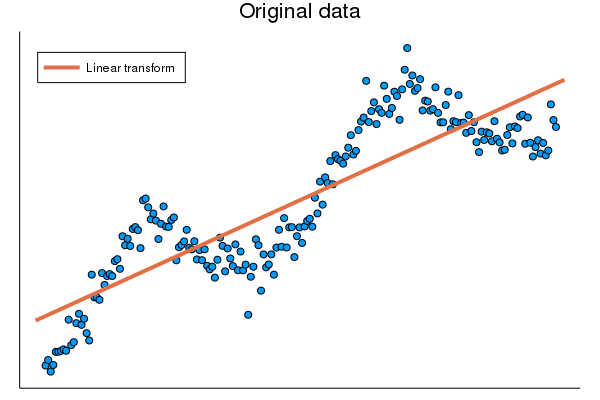

In [1]:
using Plots, Random; 
Random.seed!(0); 
xs = range(0, stop=10, length=200); 
ys = randn.() .+ xs .+ 0.5.*xs.^1.5 .+ 6.0.*sin.(clamp.(xs .- 5, 0, Inf)) .+ 4.5.*clamp.(.-abs.(xs .- 2), -2, 0); 
scatter(xs, ys, label="", ticks = false, title="Original data", ylim=extrema(ys).+[-.5,.5], fmt=:png); 
fit1 = [xs ones(size(xs))] \ ys; 
linear1(x) = fit1[1]*x + fit1[2]; 
plot!(linear1, label="Linear transform", linewidth=4, legend=:topleft)

A nonlinear transformation—such as the sigmoid function or a piecewise linear function—then adds a bump to this linearly-transformed data:

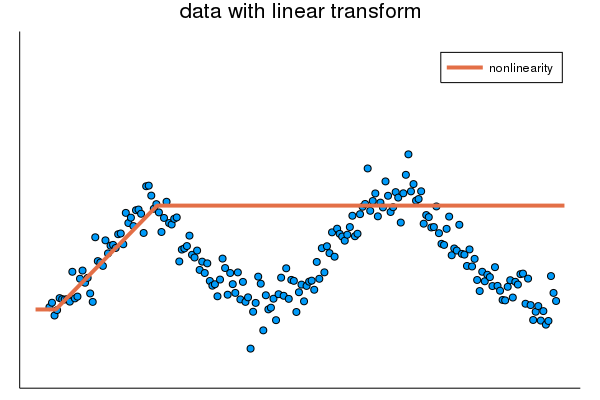

In [2]:
scatter(xs, ys .- linear1.(xs), ticks = false, label = "", title="data with linear transform", 
    ylim=extrema(ys).+[-.5,.5], fmt=:png);
nonlinearity(x) = clamp.(4.0.*x .- 4.5, -4, 4); 
plot!(nonlinearity, label = "nonlinearity", linewidth=4)

Resulting in a bit more of the data accounted for:

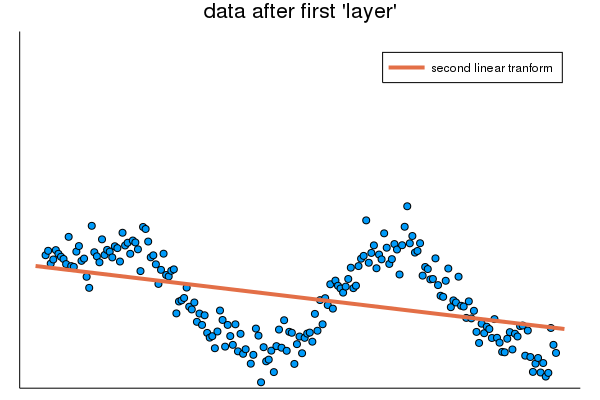

In [3]:
ys2 = ys .- linear1.(xs) .- nonlinearity.(xs); 
scatter(xs, ys2, ticks = false, label = "", title="data after first 'layer'", 
    ylim=extrema(ys).+[-.5,.5],fmt=:png);
fit2 = [xs ones(size(xs))] \ ys2; linear2(x) = fit2[1]*x + fit2[2]; 
plot!(linear2, label="second linear tranform", linewidth=4)

Now let's repeat this process. When we send the data through another layer of neurons, we get another rotation and another "bump":

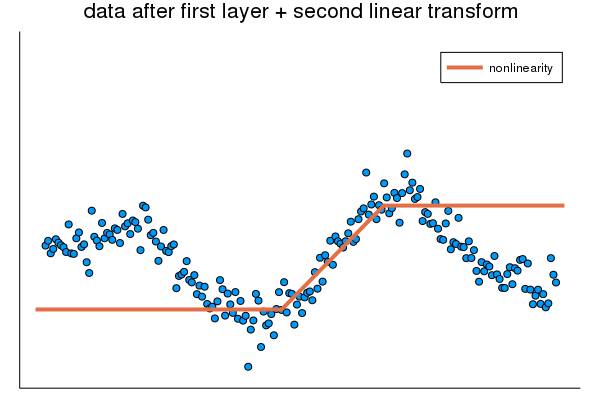

In [4]:
ys3 = ys2 .- linear2.(xs); 
scatter(xs .- 4.5, ys3, ticks = false, label = "", 
    title="data after first layer + second linear transform", 
    ylim=extrema(ys).+[-.5,.5], fmt=:png) 
plot!(nonlinearity, label = "nonlinearity", linewidth=4)

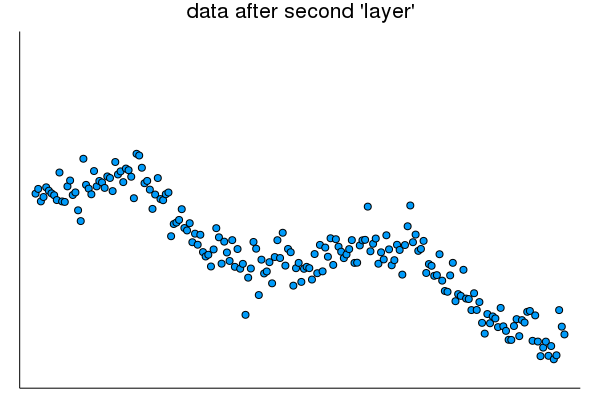

In [5]:
ys4 = ys3 .- nonlinearity.(xs .- 4.5); 
scatter(xs, ys4, ticks = false, label = "", title="data after second 'layer'", 
    ylim=extrema(ys).+[-.5,.5], fmt=:png)


Visually, we see that if we keep doing this process we can make the axis line up with any data. What this means is that **if we have enough layers, then our neural network can approximate any model**.

The trade-off is that with more layers we have more parameters, so it may be harder (i.e. computationally intensive) to train the neural network. But we have the guarantee that the model has enough freedom such that there are parameters that will give the correct output.

Because this model is so flexible, the problem is reduced to that of learning: do the same gradient descent method on this much larger model (but more efficiently!) and we can make it classify our data correctly. This is the power of deep learning.

**Important caveat**: The above is a _cartoon_ that loosely describes the concepts behind a deep neural network. In reality, remember that we're not successively fitting "the best" linear transformation and then subsequently fitting a nonlinearity; the two are happening simultaneously through gradient descent. This allows the linear transform to — in effect — rotate and stretch the data such that the nonlinearity "falls" in the appropriate place to best minimize the loss function.

# Deep learning with Flux

Let's load the same datasets from the previous lecture and pre-process them in the same way:

In [6]:
using CSV, DataFrames, Flux, Plots
apples1 = DataFrame(CSV.File("data/Apple_Golden_1.dat", delim='\t', allowmissing=:none, normalizenames=true))
apples2 = DataFrame(CSV.File("data/Apple_Golden_2.dat", delim='\t', allowmissing=:none, normalizenames=true))
apples3 = DataFrame(CSV.File("data/Apple_Golden_3.dat", delim='\t', allowmissing=:none, normalizenames=true))
apples = vcat(apples1, apples2, apples3)
bananas = DataFrame(CSV.File("data/Banana.dat", delim='\t', allowmissing=:none, normalizenames=true))
grapes1 = DataFrame(CSV.File("data/Grape_White.dat", delim='\t', allowmissing=:none, normalizenames=true))
grapes2 = DataFrame(CSV.File("data/Grape_White_2.dat", delim='\t', allowmissing=:none, normalizenames=true))
grapes = vcat(grapes1, grapes2)
# Extract out the features and construct the corresponding labels
x_apples  = [ [apples[i, :red], apples[i, :blue]] for i in 1:size(apples, 1) ]
x_bananas  = [ [bananas[i, :red], bananas[i, :blue]] for i in 1:size(bananas, 1) ]
x_grapes = [ [grapes[i, :red], grapes[i, :blue]] for i in 1:size(grapes, 1) ]
xs = vcat(x_apples, x_bananas, x_grapes)
ys = vcat(fill(Flux.onehot(1, 1:3), size(x_apples)),
          fill(Flux.onehot(2, 1:3), size(x_bananas)),
          fill(Flux.onehot(3, 1:3), size(x_grapes)));

loaded


In the previous lecture, we used a `Dense(2, 3, σ)` as our model. Now we want to construct multiple layers and chain them together:

In [7]:
layer1 = Dense(2, 4, σ)
layer2 = Dense(4, 3, σ)

Dense(4, 3, NNlib.σ)

In [8]:
layer2(layer1(xs[1]))

Tracked 3-element Array{Float32,1}:
 0.31955788f0
 0.63294536f0
 0.44320068f0

In [9]:
?Chain

search: Chain



```
Chain(layers...)
```

Chain multiple layers / functions together, so that they are called in sequence on a given input.

```julia
m = Chain(x -> x^2, x -> x+1)
m(5) == 26

m = Chain(Dense(10, 5), Dense(5, 2))
x = rand(10)
m(x) == m[2](m[1](x))
```

`Chain` also supports indexing and slicing, e.g. `m[2]` or `m[1:end-1]`. `m[1:3](x)` will calculate the output of the first three layers.


In [10]:
m = Chain(layer1, layer2)
m(xs[1])

Tracked 3-element Array{Float32,1}:
 0.31955788f0
 0.63294536f0
 0.44320068f0

In [11]:
xs[1] |> layer1 |> layer2

Tracked 3-element Array{Float32,1}:
 0.31955788f0
 0.63294536f0
 0.44320068f0

### The core algorithm from the last lecture

In [12]:
# model = Chain(Dense(2, 3, σ)) # Update this!
model = Chain(layer1, layer2)
L(x,y) = Flux.mse(model(x), y)
# opt = SGD(params(model))
opt = Descent(0.1)
Flux.train!(L, params(model),zip(xs, ys), opt)

In [13]:
data = zip(xs, ys)
@time Flux.train!(L, params(model), data, opt)
@time Flux.train!(L, params(model), data, opt)

  0.504968 seconds (1.58 M allocations: 44.248 MiB, 4.25% gc time)
  0.485624 seconds (1.58 M allocations: 44.248 MiB, 6.28% gc time)


### Improving efficiency by batching

In [14]:
length(data)

2935

In [15]:
first(data)

([0.708703, 0.341998], Bool[true, false, false])

Recall our matrix-vector multiplication from the previous lecture:

In [16]:
W = [10 1;
     20 2;
     30 3]
x = [3;
     2]
W*x

3-element Array{Int64,1}:
 32
 64
 96

In [17]:
Flux.batch(xs)

2×2935 Array{Float64,2}:
 0.708703  0.648376  0.647237  0.647963  …  0.721761  0.722839  0.722266
 0.341998  0.284163  0.282579  0.283689     0.416422  0.417423  0.417273

In [18]:
model(Flux.batch(xs))

Tracked 3×2935 Array{Float32,2}:
 0.0529254  0.0515206  0.051472   …  0.0562094  0.0562344  0.05624  
 0.067884   0.0686408  0.0686572     0.0675046  0.0674917  0.0674973
 0.925221   0.924706   0.924695      0.925454   0.925463   0.925459 

In [19]:
databatch = (Flux.batch(xs), Flux.batch(ys))
@time Flux.train!(L, params(model), (databatch,), opt)
@time Flux.train!(L, params(model), (databatch,), opt)

  2.542434 seconds (4.86 M allocations: 250.944 MiB, 7.05% gc time)
  0.002109 seconds (604 allocations: 672.234 KiB)


In [20]:
Flux.train!(L, params(model), Iterators.repeated(databatch, 10000), opt)

In [21]:
L(databatch[1], databatch[2])

0.18400466f0 (tracked)

### Visualization

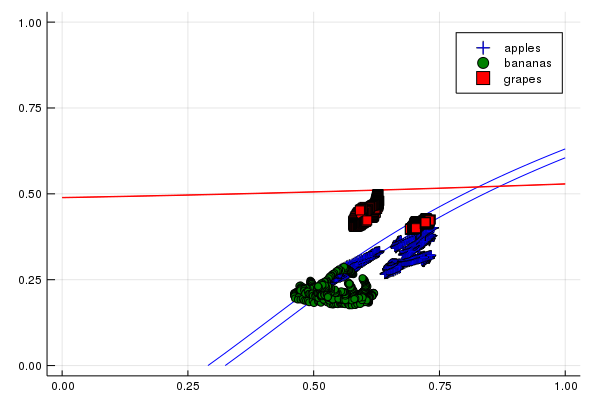

In [22]:
using Plots
function plot_decision_boundaries(model, x_apples, x_bananas, x_grapes)
    plot(fmt=:png)

    contour!(0:0.01:1, 0:0.01:1, (x,y)->model([x,y]).data[1], levels=[0.5, 0.501], color = cgrad([:blue, :blue]), colorbar=:none)
    contour!(0:0.01:1, 0:0.01:1, (x,y)->model([x,y]).data[2], levels=[0.5,0.501], color = cgrad([:green, :green]), colorbar=:none)
    contour!(0:0.01:1, 0:0.01:1, (x,y)->model([x,y]).data[3], levels=[0.5,0.501], color = cgrad([:red, :red]), colorbar=:none)

    scatter!(first.(x_apples), last.(x_apples), m=:cross, label="apples", color = :blue)
    scatter!(first.(x_bananas), last.(x_bananas), m=:circle, label="bananas", color = :green)
    scatter!(first.(x_grapes), last.(x_grapes), m=:square, label="grapes", color = :red)
end
plot_decision_boundaries(model, x_apples, x_bananas, x_grapes)

### Further improvements with a better loss function and normalization of outputs

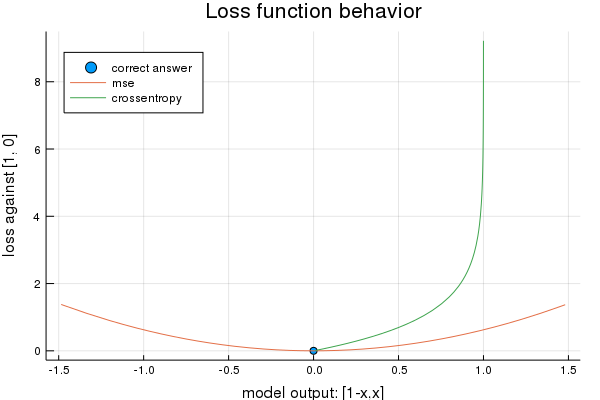

In [30]:
scatter([0],[0], label="correct answer", 
    xlabel="model output: [1-x,x]", 
    ylabel="loss against [1, 0]", 
    legend=:topleft, 
    title="Loss function behavior", fmt=:png)
plot!(x->Flux.mse([1-x, x/2], [1,0]), -1.5, 1.5, label="mse")
plot!(x->Flux.crossentropy([1-x, x/2], [1,0]), 0, 1, label="crossentropy")

In [24]:
sum(model(xs[1]))

1.0427201f0 (tracked)

In [25]:
Flux.mse([0.01,0.98,0.01], [1.0,0,0])

0.6468666666666666

In [26]:
softmax([1.0,-3,0])

3-element Array{Float64,1}:
 0.7213991842739687  
 0.013212886953789414
 0.26538792877224193 

### The new algorithm

Use `softmax` as a final normalization and change the loss function to `crossentropy`:

In [27]:
model = Chain(Dense(2, 4, σ), Dense(4, 3, identity), softmax)
L(x,y) = Flux.crossentropy(model(x), y)
# opt = SGD(params(model))
opt = Descent(0.1)

Descent(0.1)

In [28]:
Flux.train!(L, params(model), Iterators.repeated(databatch,5000), opt)

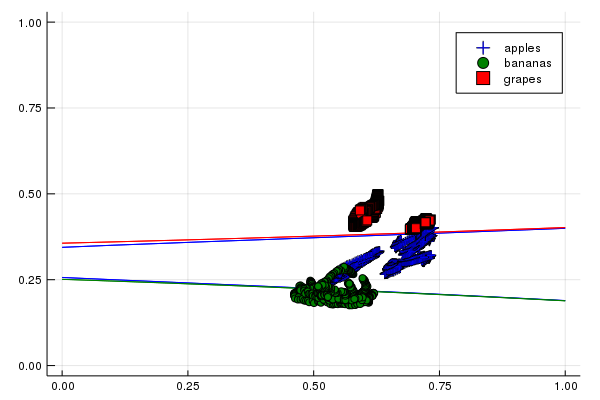

In [29]:
plot_decision_boundaries(model, x_apples, x_bananas, x_grapes)